
- does lspi work?
    - linear yes...
    - rbf no...
- how does linear lspi behave according to D? 
    - only optimal - yes
    - noisy optimal - yes
    - completely random - no

- dimensionality

- how does rbf lspi behave according to D? 
    - only optimal 
    - noisy optimal
    - completely random

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", palette="husl")

%load_ext autoreload
%autoreload 2

import numpy as np
import gym
import sys
import os
if "../" not in sys.path:
    sys.path.insert(0, "../")

from algo.lstd import LSTDQ, LSTDMu, LSPI
from algo.policy import RandomPolicy2, LinearQ2
from env.simulator import * 
from util.plotting import *
from util.basis import *
from algo.fa import LinearQ3

from logger import *
setup_logging(default_level=logging.INFO)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
env_id = "MountainCar-v0"
env = gym.envs.make(env_id)
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [34]:
# linear basis func
p_linear = 3
q_linear = 3
phi_linear = get_linear_basis()
psi_linear = phi_linear

n_component = 7
p_rbf = n_component * 4 + 1
q_rbf = n_component * 4 + 1
phi_rbf = get_rbf_basis(env, n_component=n_component)
psi_rbf = phi_rbf

phi = phi_rbf
p = p_rbf

precision = 1e-8
eps = 0.0
gamma = 0.99
action_list = range(env.action_space.n)

/home/dhfromkorea/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Step 161 @ Episode 70/70 (-200.0)

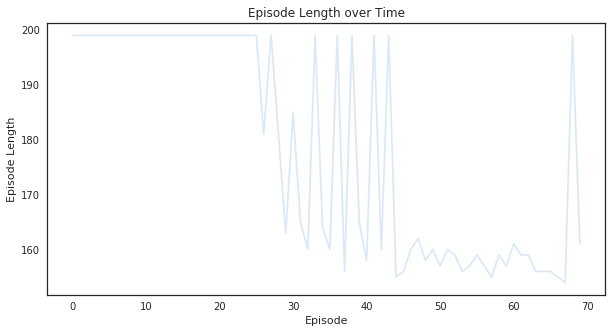

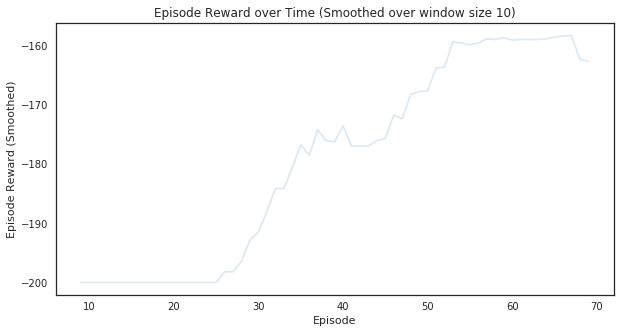

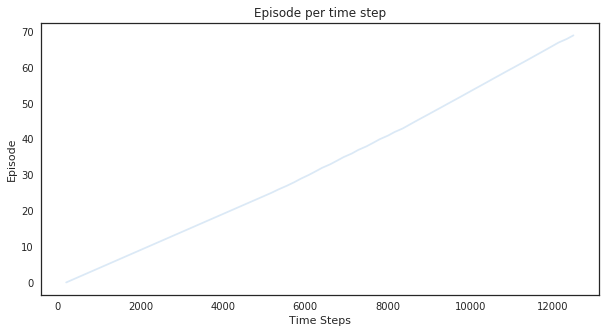

(<matplotlib.figure.Figure at 0x7f57d88b10b8>,
 <matplotlib.figure.Figure at 0x7f57d67e00f0>)

In [4]:
# one reason: basis function includes action (remove... but how?)
# swapping with the original code copy paste
# estimator update?
mdp_solver = LinearQ3(env=env,
                      phi=phi,
                      action_list=action_list,
                      n_episode=70,
                      epsilon=0.0,
                      epsilon_decay=1.0,
                      gamma=gamma)

pi_expert, stats = mdp_solver.solve()
#plotting.plot_cost_to_go_mountain_car(env, pi_expert._estimator)
plotting.plot_episode_stats(stats, smoothing_window=10)


In [5]:
class NearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        return 0 if v <=0 else 2
pi_near = NearExpertPolicy()
pi_random = RandomPolicy2(action_list)
#D, stats = sim.simulate(pi=pi_expert, n_trial=1, n_episode=100, return_stats=True)

pi_list = [pi_random, pi_near]
mix_ratio = [0.2, 0.8]
sample_size = 50
D = sim.simulate_mixed(env, pi_list, sample_size, mix_ratio)

Step 158 @ Episode 40/40 (-89.0))

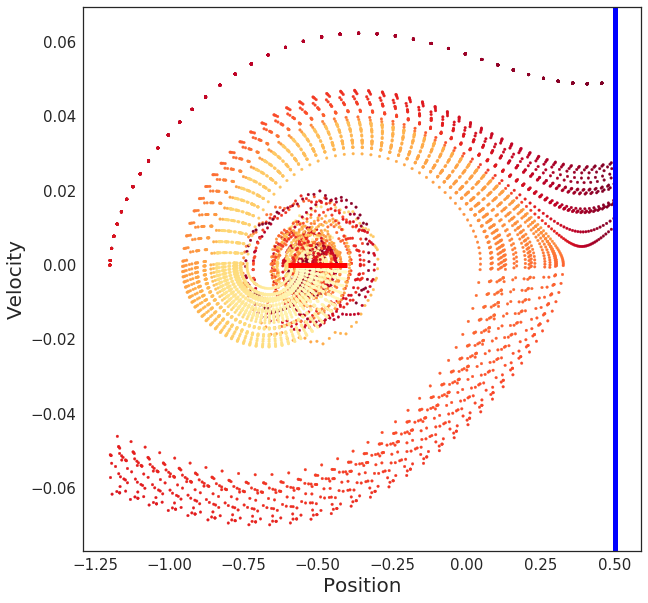

In [6]:
#plot_cost_to_go_mountain_car(env, pi_irl._estimator)
#plot_episode_stats(stZts, smoothing_window=5)
#dir(Simulator.to_matrix)
plot_trajectory_mountain_car(D)

In [16]:
def solve_mountain_car(p, phi, gamma, precision, eps, D, reward_fn=None):  
    W_0 = np.random.rand(p)
    lspi = LSPI(D=D,
                action_list=action_list,
                p=p,
                phi=phi,
                gamma=gamma,
                precision=precision,
                eps=eps,
                W_0=W_0,
                reward_fn=reward_fn)

    W, w_list = lspi.solve()
    return W, w_list

D_mat = Simulator.to_matrix(D)

In [28]:
# preprocess reward if needed
def reward_fn1(s, a):
    pos, v = s
    return 1 if pos > 0.5 else 0

def reward_fn2(s, a):
    pos, v = s
    return 2*(pos + 0.5)**2

def reward_fn(s, a):
    pos, v = s
    if pos < -0.75:
        return 1
    if pos > -0.25:
        return 1
    if pos > 0.5:
        return 10
    return -1


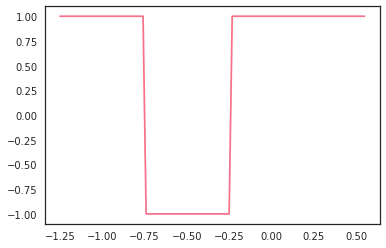

In [26]:
xx = np.linspace(-1.25, 0.55, 100)
r = [reward_fn([x, 0], 0) for x in xx]
plt.plot(xx, r)

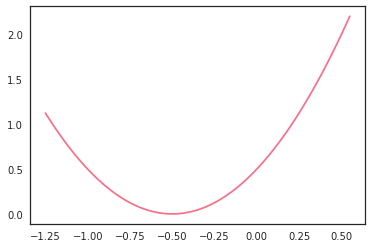

In [29]:
xx = np.linspace(-1.25, 0.55, 100)
r = [reward_fn2([x, 0], 0) for x in xx]
plt.plot(xx, r)

(array([4656.,  809.,  398.,  467.,  408.,  214.,  153.,   81.,   79.,
          69.]),
 array([3.54255266e-10, 1.99792116e-01, 3.99584232e-01, 5.99376347e-01,
        7.99168463e-01, 9.98960578e-01, 1.19875269e+00, 1.39854481e+00,
        1.59833692e+00, 1.79812904e+00, 1.99792116e+00]),
 <a list of 10 Patch objects>)

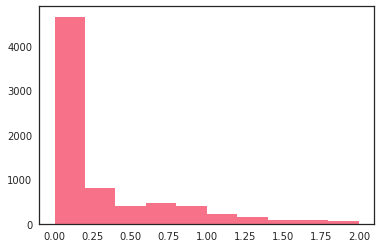

In [32]:
s = np.vstack(D_mat[:, 0])
a = np.vstack(D_mat[:, 1])
r = np.vstack([reward_fn2(s,a) for s, a in zip(s, a)])
plt.hist(r)

In [38]:
print("batch data size {}".format(np.array(D_mat).shape))
#W_linear = solve_mountain_car_linear(p_linear, phi_linear, gamma, precision, eps, D_mat, reward_fn)
w_rbf, w_list = solve_mountain_car(p_rbf, phi_rbf, gamma, precision, eps, D_mat, reward_fn2)

INFO:root:fitting D of the dimension:
(7334, 5)


batch data size (7334, 5)


INFO:root:lspi norm 448.02639219676206
INFO:root:lspi norm 150.53026541115406
INFO:root:lspi norm 656.0710487283993
INFO:root:lspi norm 589.5906555777901
INFO:root:lspi norm 468.948455225292
INFO:root:lspi norm 1020.2509154717393
INFO:root:lspi norm 1208.4333874006
INFO:root:lspi norm 83.35768928233315
INFO:root:lspi norm 495767.577314948
INFO:root:lspi norm 495759.7959458421
INFO:root:lspi norm 291.1173485096922
INFO:root:lspi norm 134.70385557751982


ValueError: too many values to unpack (expected 2)

Step 198 @ Episode 30/30 (-200.0)

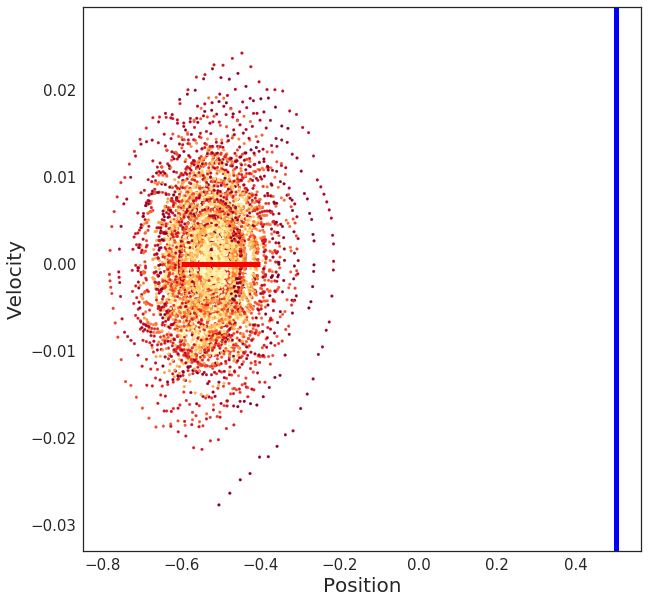

In [45]:
for w in w_list: 
    pi_star = LinearQ2(action_list=action_list, phi=phi_rbf, W=w)
    #pi_star = LinearQ2(action_list=action_list, phi=phi_linear, W=W_linear)
    D_star, stats = sim.simulate(pi=pi_star, n_trial=1, n_episode=30, return_stats=True)
    plot_trajectory_mountain_car(D_star)    